# Harmful Algal Bloom (HAB) Detection from Wyvern hyperspectral imagery, Exploratory Data Analysis (EDA)

- Begin by generating a water mask with Normalized Difference Water Index (NDWI)
- Then calculate:
    - Blue-Green Algate Index (BGI)
    - Floating Algae Index - adaptation (FAI)
    - and Normalized Difference Chloropyll Index (NDCI)


## Read green and NIR bands

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from rasterio.features import shapes
from shapely.geometry import shape, mapping
import geopandas as gpd
from PIL import Image

In [3]:
tampico_mx = "wyvern_dragonette-003_20241229T165203_12324bcb.tiff"  # https://wyvern-prod-public-open-data-program.s3.ca-central-1.amazonaws.com/wyvern_dragonette-003_20241229T165203_12324bcb/wyvern_dragonette-003_20241229T165203_12324bcb.tiff

tampico_mx_data_mask = "wyvern_dragonette-003_20241229T165203_12324bcb_data_mask.tiff"  # https://wyvern-prod-public-open-data-program.s3.ca-central-1.amazonaws.com/wyvern_dragonette-003_20241229T165203_12324bcb/wyvern_dragonette-003_20241229T165203_12324bcb_data_mask.tiff

overview_img = "https://wyvern-prod-public-open-data-program.s3.ca-central-1.amazonaws.com/wyvern_dragonette-003_20241229T165203_12324bcb/wyvern_dragonette-003_20241229T165203_12324bcb_preview.png"

## Visualize Wyvern preview image for this scene (PNG)

Note there does not appear to be any cloud cover.

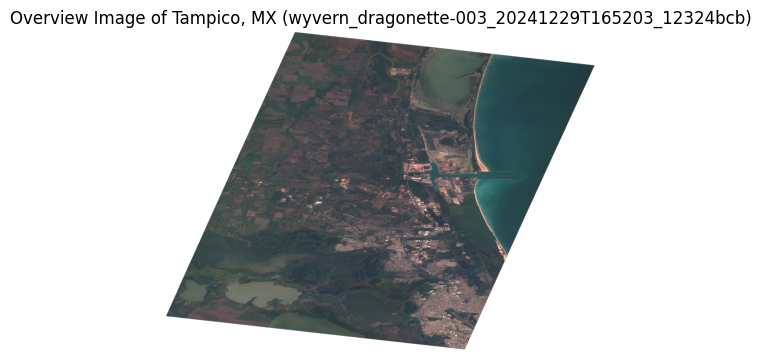

In [4]:
response = requests.get(overview_img)
img = Image.open(BytesIO(response.content))

plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.title("Overview Image of Tampico, MX (wyvern_dragonette-003_20241229T165203_12324bcb)")
plt.axis("off")
plt.tight_layout()
plt.show()

## Read Green, Red, Red-Edge and NIR bands

The wavelengths are selected from the 31 available bands in the Wyvern hyperspectral imagery. They are matched with
the formulas for NDWI, BGI, FAI-like, and NDCI.

In [ ]:
with rio.open(tampico_mx) as src:
    # Green 550nm
    band_green_r550 = src.descriptions.index("Band_550")
    green_r550 = src.read(band_green_r550 + 1)
    green_r550_nodata = src.nodatavals[band_green_r550]

    # Red 669nm
    band_red_r669 = src.descriptions.index("Band_669")
    red_r669 = src.read(band_red_r669 + 1)
    red_r669_nodata = src.nodatavals[band_red_r669]

    # Red-Edge 700nm
    band_red_edge_r700 = src.descriptions.index("Band_700")
    red_edge_r700 = src.read(band_red_edge_r700 + 1)
    red_edge_r700_nodata = src.nodatavals[band_red_edge_r700]

    # NIR 869nm
    band_nir_r869 = src.descriptions.index("Band_869")
    nir_r869 = src.read(band_nir_r869 + 1)
    nir_r869_nodata = src.nodatavals[band_nir_r869]

    profile = src.profile

## Make validity masks using NODATA values

In [1]:
green_r550[green_r550 == green_r550_nodata] = np.nan
nir_r869[nir_r869 == nir_r869_nodata] = np.nan
green_r550_valid_mask = ~np.isnan(green_r550) 
nir_r869_valid_mask = ~np.isnan(nir_r869)

# TODO: red and red_edge 

NameError: name 'np' is not defined

## Visualize "cloud" mask and "clear" QA masks

Are there clouds which need to be masked out? Wyvern provides a side-car QA raster (`*_data_mask.tiff`).

In [27]:
with rio.open(tampico_mx_data_mask) as src:
    band_cloud_mask = src.descriptions.index("QA_CLOUD_MASK")
    band_clear_mask =src.descriptions.index("QA_CLEAR_MASK")
    cloud_mask = src.read(band_cloud_mask + 1)
    clear_mask = src.read(band_clear_mask + 1)

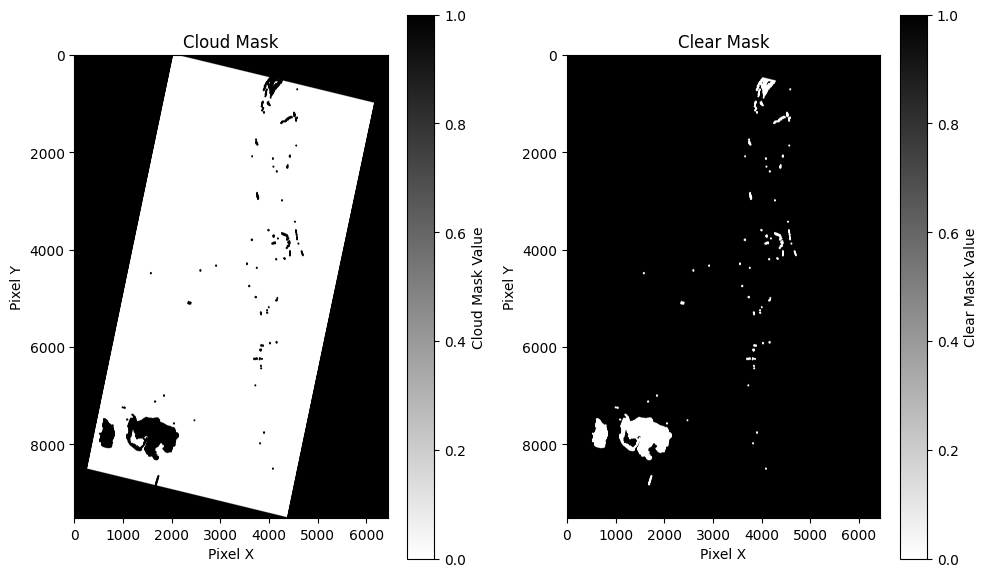

In [28]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.imshow(cloud_mask, cmap="binary", vmin=0, vmax=1)
plt.colorbar(label="Cloud Mask Value")
plt.title("Cloud Mask")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

plt.subplot(1, 2, 2)
plt.imshow(clear_mask, cmap="binary", vmin=0, vmax=1)
plt.colorbar(label="Clear Mask Value")
plt.title("Clear Mask")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

plt.tight_layout()
plt.show()

## ⚠️ Architectural decision

Do not use the clear/cloud mask layers for this workflow. They don't seem accurate, or I cannot interpret. When closely inspecting the visual preview PNG, it definitely appears to be a cloud free scene.

## Visualize the Green and NIR bands

Preview of the raw reflectance before NDWI calculation.

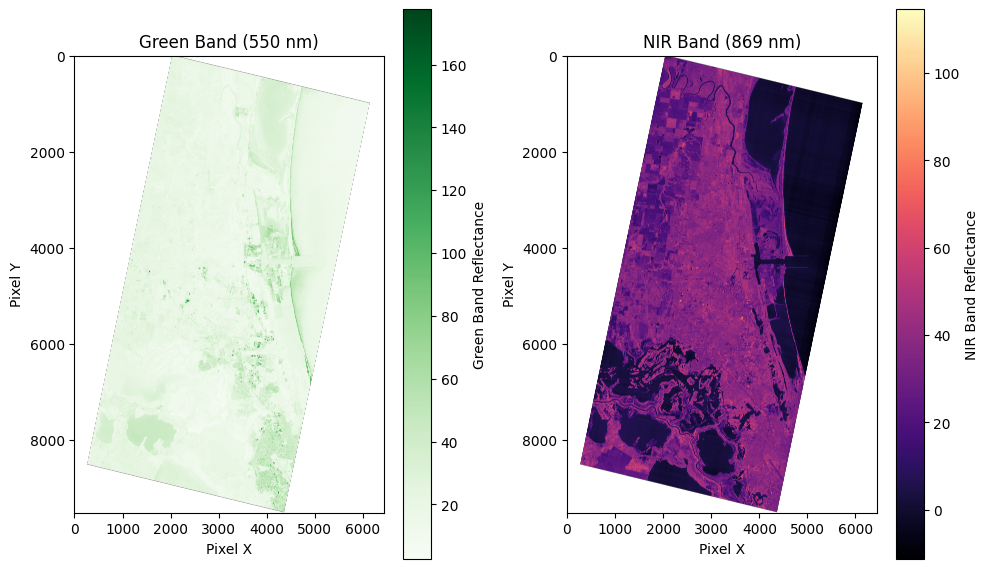

In [29]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.imshow(green_r550, cmap='Greens')
plt.colorbar(label='Green Band Reflectance')
plt.title('Green Band (550 nm)')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')

plt.subplot(1, 2, 2)
plt.imshow(nir_r869, cmap='magma')
plt.colorbar(label='NIR Band Reflectance')
plt.title('NIR Band (869 nm)')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')

plt.tight_layout()
plt.show()

## Calculate NDWI formula

The range is [0, 1] and  interpretation is 1 = water and -1 = no water.

```
NWDI = (Green - NIR) / (Green + NIR)
```

In [47]:
validity_mask = green_r550_valid_mask & nir_r869_valid_mask
validity_mask.shape

(9510, 6441)

In [48]:
ndwi = np.full_like(green_r550, np.nan)
ndwi[validity_mask] = (green_r550[validity_mask] - nir_r869[validity_mask]) / (green_r550[validity_mask] + nir_r869[validity_mask])

## Visualize NDWI raster

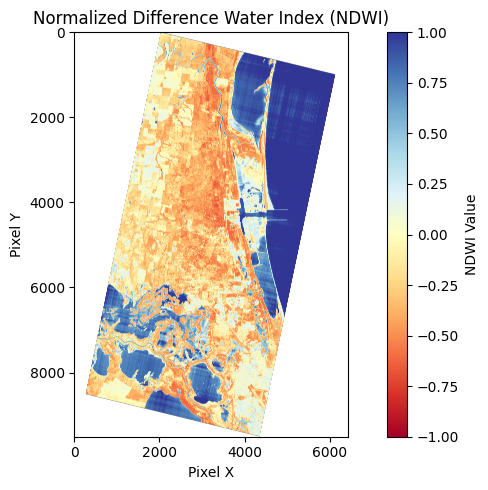

In [49]:
plt.figure(figsize=(8, 5))

plt.imshow(ndwi, cmap='RdYlBu', vmin=-1, vmax=1)
plt.colorbar(label='NDWI Value')
plt.title('Normalized Difference Water Index (NDWI)')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')

plt.tight_layout()
plt.show()

## Make a water mask raster with threshold value

By convention with NDWI, water is `> 0.3`.

In [50]:
water_threshold = 0.3
water_mask = np.zeros_like(ndwi, dtype=bool)
water_mask[validity_mask] = ndwi[validity_mask] > water_threshold

## Visualize water mask

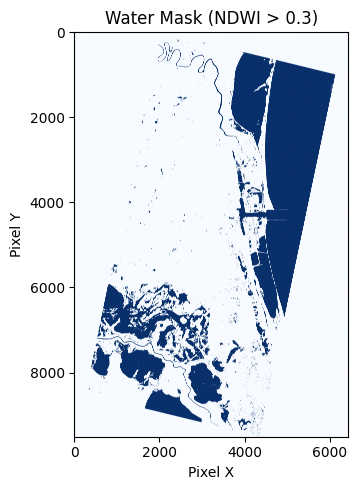

In [51]:
plt.figure(figsize=(8, 5))
plt.imshow(water_mask, cmap='Blues', vmin=0, vmax=1)
plt.title(f'Water Mask (NDWI > {water_threshold})')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.tight_layout()
plt.show()

### Polygonize the water mask area

Write to GeoJSON file.

In [ ]:
results = (
    {'properties': {'value': v}, 'geometry': s}
    for s, v in shapes(water_mask.astype(np.uint8), mask=water_mask, transform=profile['transform'])
)
geometries = [shape(result['geometry']) for result in results if result['properties']['value'] == 1]
gdf = gpd.GeoDataFrame(geometry=geometries, crs=profile['crs'])
gdf.to_file("water-mask.geojson", driver="GeoJSON")

In [ ]:
from ipyleaflet import Map, GeoJSON
import geopandas as gpd

# Load the GeoJSON file into a GeoDataFrame
gdf = gpd.read_file("water-mask.geojson")

# Create a map centered on the GeoDataFrame's centroid
# If gdf has multiple polygons, find the centroid of the whole collection
bbox = gdf.total_bounds
center = ((bbox[0] + bbox[2])/2, (bbox[1] + bbox[3])/2)
map = Map(center=(center[1], center[0]), zoom=10)

# Add the GeoDataFrame as a GeoJSON layer
geo_json = GeoJSON(data=gdf.__geo_interface__)
map.add_layer(geo_json)

# Display the map
map

Map(center=[np.float64(22.463123028176188), np.float64(-97.9201555370818)], controls=(ZoomControl(options=['po…

### Make preview image (PNG) of the water mask

Convert the water mask to an 8-bit image (0 for False, 1 for True).

In [ ]:
water_mask_uint8 = (water_mask * 255).astype(np.uint8)

image = Image.fromarray(water_mask_uint8, mode='L')
image.save("water-mask.png", optimize=True)

## Calculate Blue-Green Algae Index (BGI)

Formula: `BGA = (Band_700 / Band_669) - 1`

Why it's effective for HABs:

- Directly targets cyanobacteria (blue-green algae), which are the most common cause of harmful algal blooms
- Leverages the specific absorption features of phycocyanin (a pigment unique to cyanobacteria)
- The 700nm/669nm ratio is particularly sensitive to cyanobacterial concentrations
- Simple calculation that clearly differentiates cyanobacteria from other water features

(source: Claude 3.7)

## Calculate Floating Algae Index (FAI)-like adaptation

Formula: `FAI_adapted = Band_869 - [Band_669 + (869-669)/(869-550) * (Band_550 - Band_669)]`

Why it's useful for HABs:

- Specifically designed to detect surface scum and floating algae mats
- Many harmful algal blooms form distinct surface accumulations
- Less affected by atmospheric interference than simple band ratios
- Good at distinguishing floating algae from suspended sediment

(source: Claude 3.7)

## Calculate Normalized Difference Chlorophyll Index (NDCI)

Formula: `NDCI = (R_NIR - R_RED)/(R_NIR + R_RED)`

Why it works for HABs:

- Directly measures chlorophyll-a concentration, which increases during algal blooms
- The red-edge portion of the spectrum (712nm) is particularly sensitive to high chlorophyll levels
- Already implemented in your notebook and showing promising results

### Band selection

For the NDCI calculation, the band selection is quite specific and should focus on particular spectral features related to chlorophyll absorption and reflection. Let me explain the optimal choices:

> For R_RED, I recommend Band 17 (669 nm) because:
>    - This wavelength sits right in the chlorophyll-a absorption maximum (~670 nm)
>    - It captures the deepest part of the absorption trough in the red spectrum for phytoplankton
>    - The narrow FWHM (23.415 nm) provides precise measurement of this absorption feature

> For R_NIR, I recommend Band 21 (712 nm) instead of Band 31 (869 nm) because:
> - The 712 nm band captures the critical "red edge" position where reflectance increases sharply after chlorophyll absorption
> - This specific wavelength is sensitive to changes in chlorophyll concentration
> - Most NDCI implementations use bands around 700-720 nm rather than longer NIR wavelengths



### Read Red and NIR bands

In [56]:
with rio.open(tampico_mx) as src:
    band_id_red_r669 = src.descriptions.index("Band_669")
    band_id_nir_r712 = src.descriptions.index("Band_712")

    red_r669 = src.read(band_id_red_r669 + 1)
    nir_r712 = src.read(band_id_nir_r712 + 1)

    red_r669_nodata = src.nodatavals[band_id_red_r669]
    nir_r712_nodata = src.nodatavals[band_id_nir_r712]

    profile = src.profile

### Make validity mask using water mask, combined with NODATA values from red + nir bands.

In [58]:
red_r669[red_r669 == red_r669_nodata] = np.nan
nir_r712[nir_r712 == nir_r712_nodata] = np.nan
validity_mask = water_mask & ~np.isnan(red_r669) & ~np.isnan(nir_r712)
validity_mask.shape

(9510, 6441)

### Visualize the Red and NIR bands

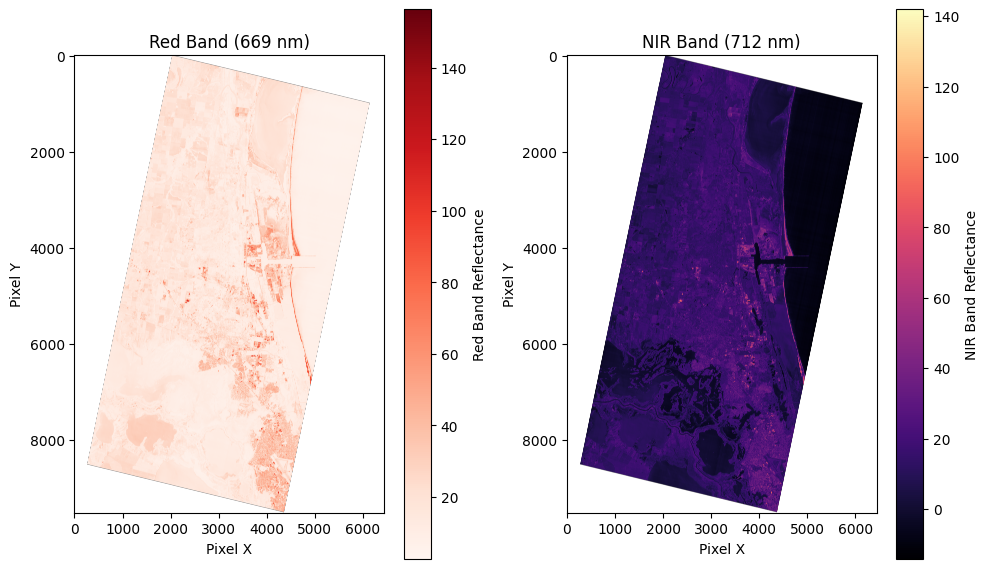

In [60]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.imshow(red_r669, cmap='Reds')
plt.colorbar(label='Red Band Reflectance')
plt.title('Red Band (669 nm)')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')

plt.subplot(1, 2, 2)
plt.imshow(nir_r712, cmap='magma')
plt.colorbar(label='NIR Band Reflectance')
plt.title('NIR Band (712 nm)')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')

plt.tight_layout()
plt.show()

### Mask the Red and NIR bands using the water mask

### NDCI calculation

`NDCI = (R_NIR - R_RED)/(R_NIR + R_RED)`

In [ ]:
ndci = np.full_like(validity_mask, np.nan, dtype=np.float32)
ndci[validity_mask] = (nir_r712[validity_mask] - red_r669[validity_mask]) / (nir_r712[validity_mask] + red_r669[validity_mask])

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]],
      shape=(9510, 6441), dtype=float32)

### Visualize NDCI Raster

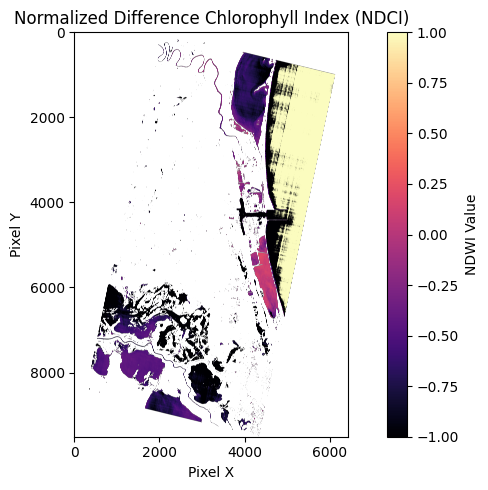

In [66]:
plt.figure(figsize=(8, 5))
plt.imshow(ndci, cmap="magma", vmin=-1, vmax=1)
plt.colorbar(label="NDWI Value")
plt.title("Normalized Difference Chlorophyll Index (NDCI)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.tight_layout()
plt.show()

### Analysis

The northeast quadrant of the scene is open ocean, and it's displaying NDCI near 1.0, which seems incorrect. The cause is, apparently, because the NIR band has negative values. Clamp negative values to zero, this could be a calibration issue or noise?

In [68]:
# Clamp NIR negative values to zero
nir_r712_clamped = np.copy(nir_r712)
nir_r712_clamped[nir_r712_clamped < 0] = 0

In [ ]:
ndci = np.full_like(validity_mask, np.nan, dtype=np.float32)
ndci[validity_mask] = (nir_r712_clamped[validity_mask] - red_r669[validity_mask]) / (nir_r712_clamped[validity_mask] + red_r669[validity_mask])

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]],
      shape=(9510, 6441), dtype=float32)

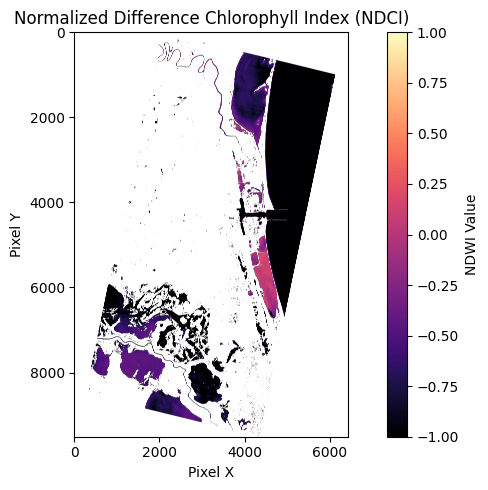

In [70]:
plt.figure(figsize=(8, 5))
plt.imshow(ndci, cmap="magma", vmin=-1, vmax=1)
plt.colorbar(label="NDWI Value")
plt.title("Normalized Difference Chlorophyll Index (NDCI)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.tight_layout()
plt.show()

### NDCI Interpretation

Higher positive values (typically >0.2): Indicate higher chlorophyll concentration, suggesting the presence of algae in water bodies.


### Make preview image (PNG) of the NDCI raster

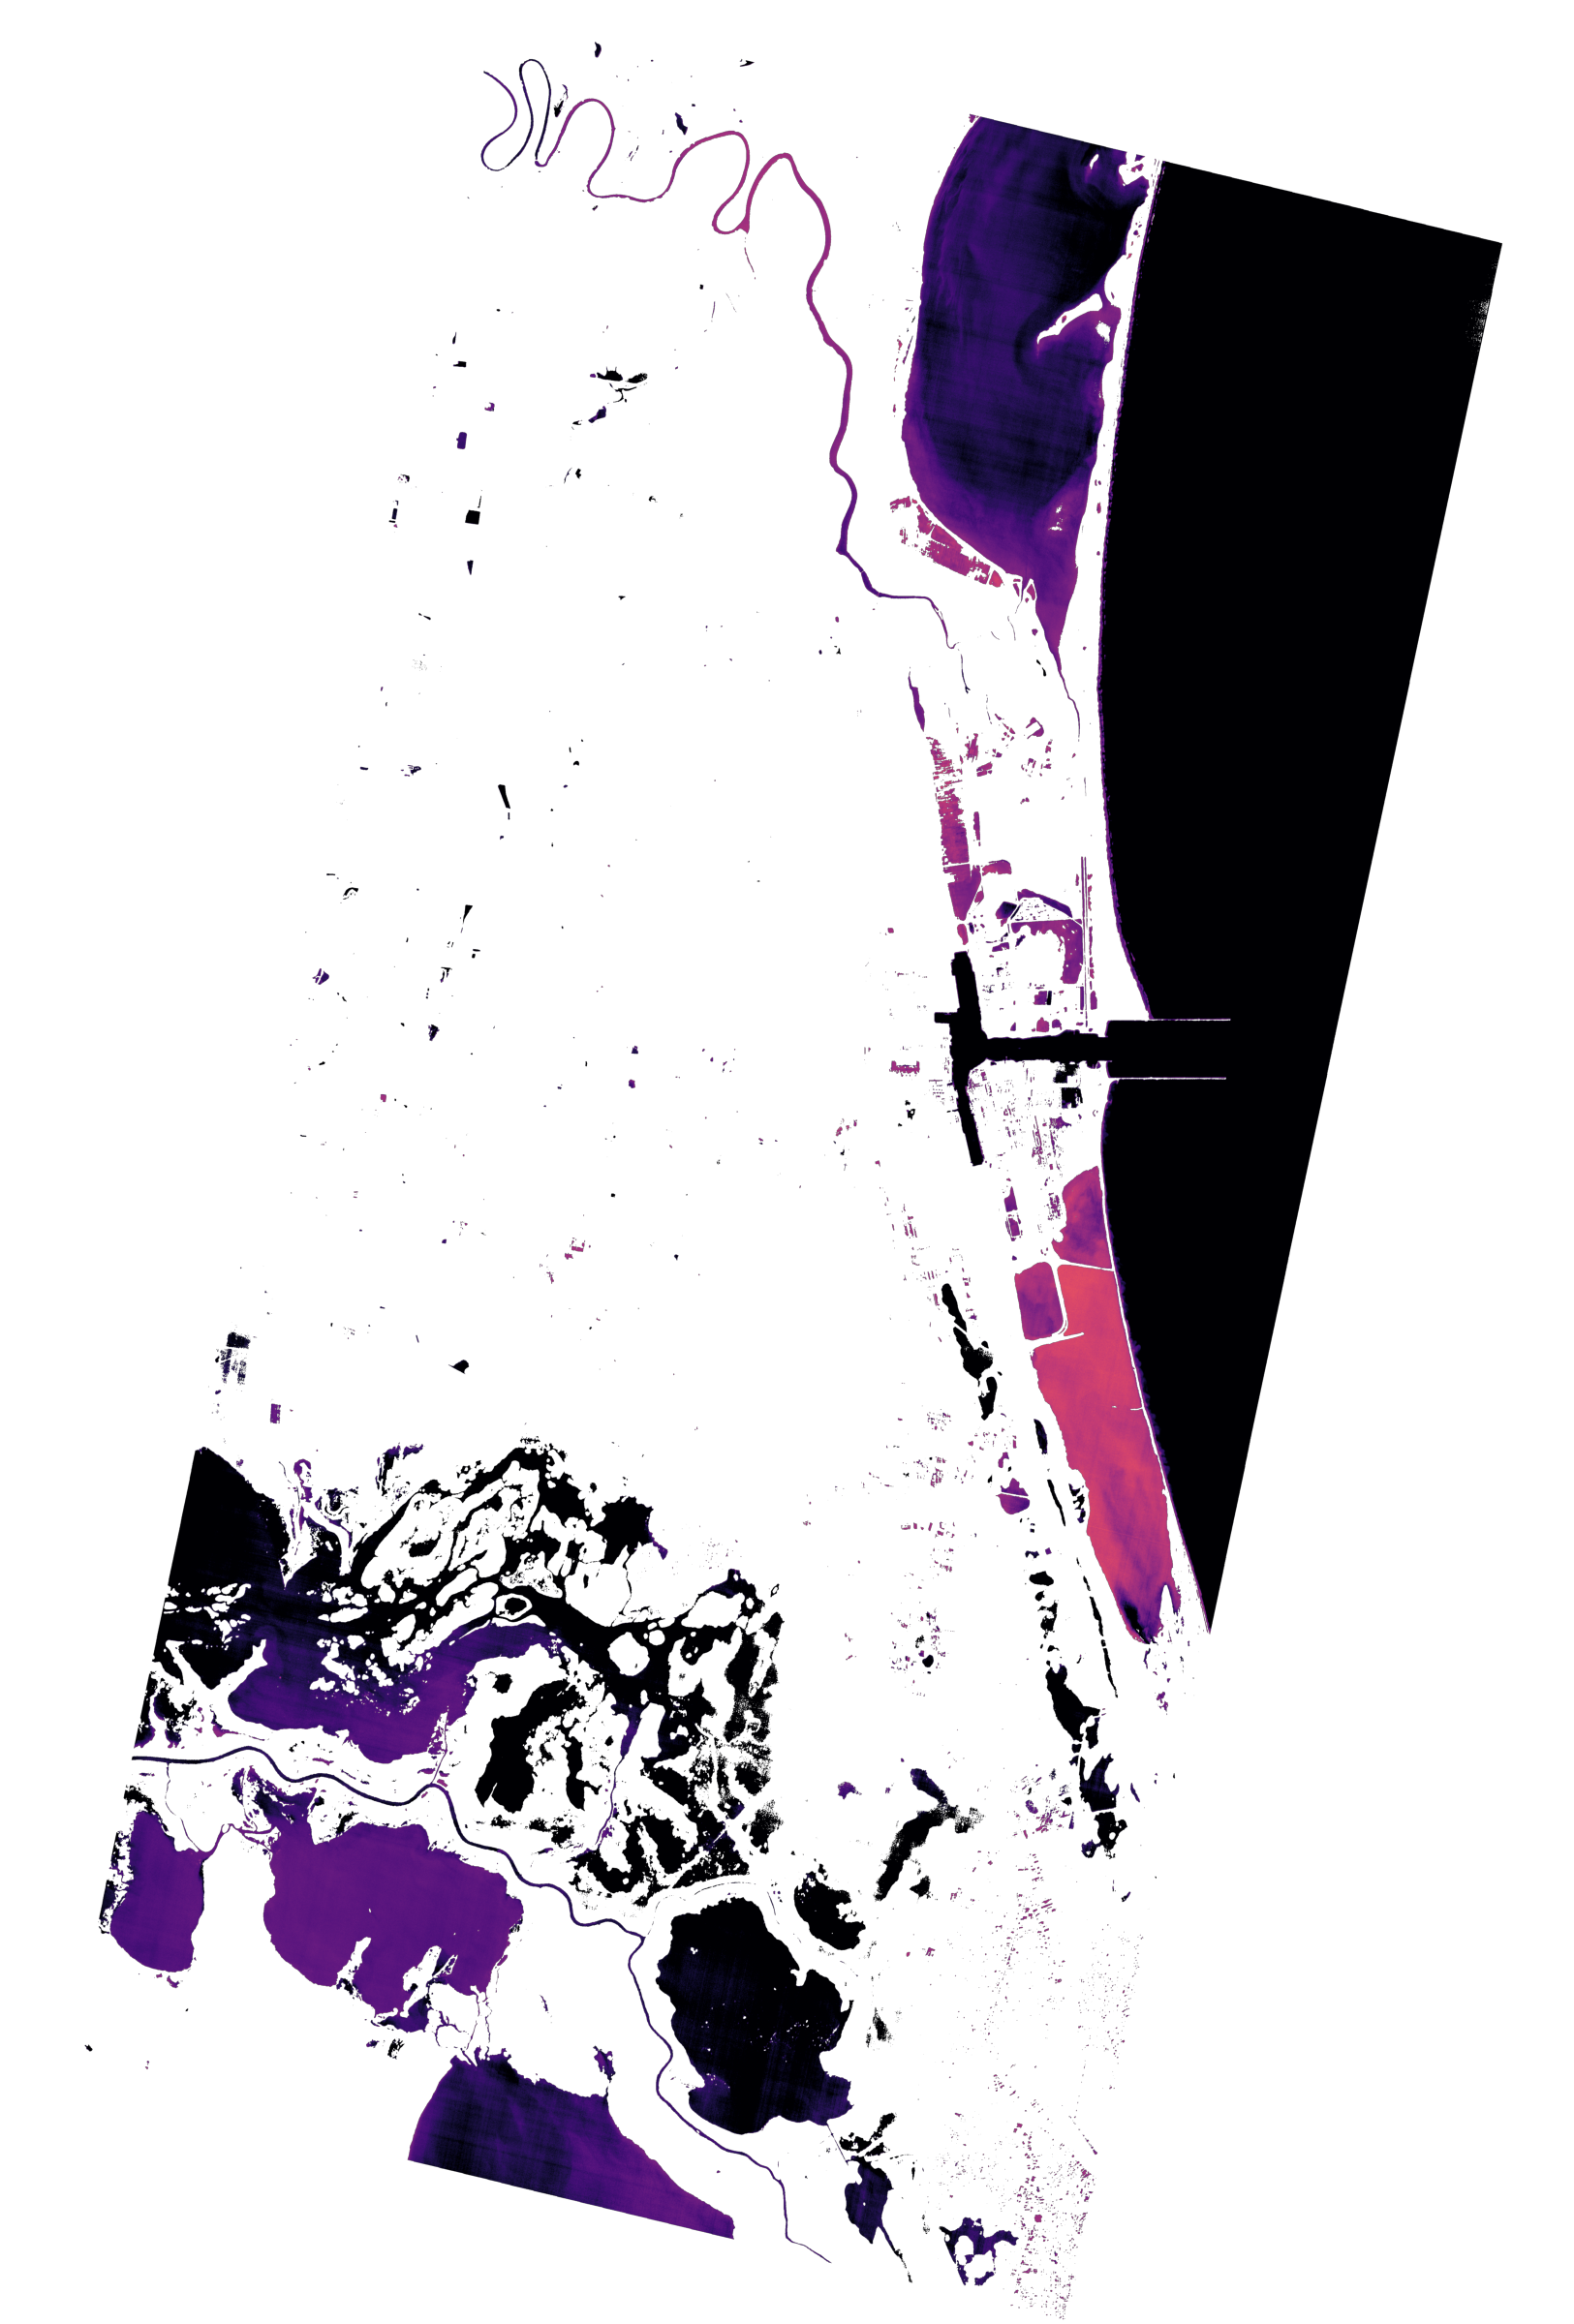

In [72]:
# Convert NDCI array to a colorful image using the magma colormap
fig = plt.figure(figsize=(10, 8), frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

# Create the color mapping with the magma colormap, set vmin and vmax to control the color range
im = ax.imshow(ndci, cmap='magma', vmin=-1, vmax=1)

# Save the figure as PNG with high DPI for better quality
plt.savefig('ndci-colormap.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.close(fig)

# Add a version with colorbar for reference
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(ndci, cmap='magma', vmin=-1, vmax=1)
plt.colorbar(im, label='NDCI Value', ax=ax)
ax.set_title('Normalized Difference Chlorophyll Index (NDCI)')
ax.set_axis_off()
plt.savefig('ndci_colormap_with_legend.png', dpi=300, bbox_inches='tight')
plt.close(fig)

# Display the saved image
img = Image.open('ndci-colormap.png')
display(img)

## Additional Normalized Indices for Algae and Water Quality Analysis

Based on the available Wyvern bands, here are several useful normalized indices you could add to your notebook to enhance your algae and water quality analysis:

1. NDVI (Normalized Difference Vegetation Index)
    `NDVI = (NIR - RED) / (NIR + RED)`

    - Use Band_849 (NIR) and Band_669 (RED)
    - Helpful for distinguishing aquatic vegetation from water
    - Values: -1 to 1 (higher values indicate vegetation)

2. Enhanced Vegetation Index (EVI)

    `EVI = 2.5 * ((NIR - RED) / (NIR + 6*RED - 7.5*BLUE + 1))`
    - Use Band_849 (NIR), Band_669 (RED), and Band_445 (BLUE)
    - Less susceptible to atmospheric effects than NDVI
    - Better for dense vegetation areas

3. Floating Algae Index (FAI-like adaptation)

Since true SWIR bands aren't available, adapt with the longest NIR band:
    `FAI_adapted = Band_869 - [Band_669 + (869-669)/(869-550) * (Band_550 - Band_669)]`

    - Good for detecting surface floating algae

4. GNDVI (Green Normalized Difference Vegetation Index)

    `GNDVI = (NIR - GREEN) / (NIR + GREEN)`

    - Use Band_849 (NIR) and Band_550 (GREEN)
    - More sensitive to chlorophyll variation than NDVI

5. BGA (Blue-Green Algae) Index

    `BGA = (Band_700 / Band_669) - 1`

    - Specifically targets blue-green algae (cyanobacteria)
    - Higher values indicate potential cyanobacteria presence

6. RVI (Red Edge Vegetation Index)

    `RVI = Band_734 / Band_700`

    - Band_700 Sensitive to chlorophyll content
    - Good for quantifying algae biomass

7. Trophic Status Index

    `TSI = Band_550 / Band_669`

    - Band_669 Correlates with lake trophic status (oligotrophic to eutrophic)
    - Higher values typically indicate more eutrophic conditions

8. MACI (Modified Anthocyanin Content Index)

    `MACI = (Band_550 - Band_722) / (Band_550 + Band_722)`

    - Can help detect some pigments associated with certain algal blooms
